In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import numpy as np

# Готовим данные

In [13]:
with open("../female-names.txt", "r") as f_in:
    female_names = f_in.readlines()

with open("../male-names.txt", "r") as f_in:
    male_names = f_in.readlines()

female_names = [x.lower().strip() for x in female_names]
male_names = [x.lower().strip() for x in male_names]
male_names.extend(female_names)

In [14]:
male_names[:10]

['аарон',
 'аба',
 'аббас',
 'абд аль-узза',
 'абдуллах',
 'абид',
 'аботур',
 'аввакум',
 'август',
 'авдей']

In [15]:
names = [x + "." for x in male_names]

# Словарь и токенайзер

In [16]:
vocab = sorted(list(set("".join(names))), key=lambda v: "\t" if v == "." else v)
vocab_size = len(vocab)

In [17]:
char_to_index = {char: index for index, char in enumerate(vocab)}
index_to_char = {index: char for char, index in char_to_index.items()}

def tokenize(char):
    return char_to_index.get(char, 0) 

def untokenize(index):
    return index_to_char.get(index, ".")

In [18]:
print(f"Токен для буквы а {tokenize("а")}")
print(f"Буква для токена 13 = {untokenize(13)}")

Токен для буквы а 3
Буква для токена 13 = к


# Готовим данные для обучения

In [19]:
names[:3]

['аарон.', 'аба.', 'аббас.']

In [20]:
X,Y = [], []
for n in names[:3]:
    x = "..."
    for i in range(len(n)):
        y = n[i]
        print(f"{x} -> {y}")
        X.append([tokenize(xi) for xi in x])
        Y.append(tokenize(y))
        x = (x + y)[1:]

... -> а
..а -> а
.аа -> р
аар -> о
аро -> н
рон -> .
... -> а
..а -> б
.аб -> а
аба -> .
... -> а
..а -> б
.аб -> б
абб -> а
бба -> с
бас -> .


In [21]:
print(X)
print(Y)

[[0, 0, 0], [0, 0, 3], [0, 3, 3], [3, 3, 19], [3, 19, 17], [19, 17, 16], [0, 0, 0], [0, 0, 3], [0, 3, 4], [3, 4, 3], [0, 0, 0], [0, 0, 3], [0, 3, 4], [3, 4, 4], [4, 4, 3], [4, 3, 20]]
[3, 3, 19, 17, 16, 0, 3, 4, 3, 0, 3, 4, 4, 3, 20, 0]


In [22]:
def build_dataset(words):
    X,Y = [], []
    for n in words:
        x = "..."
        for i in range(len(n)):
            y = n[i]
            #print(f"{x} -> {y}")
            X.append([tokenize(xi) for xi in x])
            Y.append(tokenize(y))
            x = (x + y)[1:]
    return [torch.tensor(j) for j in (X,Y)]
    

### Разобъем на train/dev/test

In [23]:
import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])


# Модель в матрицах

## Определение модели

In [109]:
emb_d = 10
n_tokens = 3
inner_d = 100
C = torch.randn([vocab_size, emb_d])
W1 = torch.randn([n_tokens * emb_d, inner_d])
B1 = torch.rand(inner_d)
W2 = torch.randn([inner_d, vocab_size])
B2 = torch.randn(vocab_size)

In [110]:
parameters = [C, W1, W2, B1, B2]
for p in parameters:
  p.requires_grad = True

In [111]:
sum(p.nelement() for p in parameters) # number of parameters in total

6874

## Forward

In [112]:
Xemb = F.one_hot(Xtr, num_classes = vocab_size).float() @ C
inner_layer = (Xemb.view(Xemb.shape[0], -1) @ W1 + B1).relu()
logits = inner_layer @ W2 + B2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(77.5319, grad_fn=<NllLossBackward0>)

## Backward

In [113]:
for p in parameters:
  p.grad = None

In [114]:
loss.backward()

In [115]:
for p in parameters:
  p.data -= 0.01 * p.grad

## Repeat cycle

In [117]:
ls = []
lsdev = []
for i in range(100000):
    idx = torch.randint(0, Xtr.shape[0], (32,))
    
    Xemb = F.one_hot(Xtr[idx], num_classes = vocab_size).float() @ C
    inner_layer = (Xemb.view(Xemb.shape[0], -1) @ W1 + B1).relu()
    logits = inner_layer @ W2 + B2
    loss = F.cross_entropy(logits, Ytr[idx])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 50000 else 0.01
    
    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:

        Xemb = F.one_hot(Xdev, num_classes = vocab_size).float() @ C
        inner_layer = (Xemb.view(Xemb.shape[0], -1) @ W1 + B1).relu()
        logits = inner_layer @ W2 + B2
        lossd = F.cross_entropy(logits, Ydev)

        
        print(f"{i}: Loss train {loss.item():.4f} loss dev {lossd.item():.4f}")

    ls.append(loss.item())


0: Loss train 75.8870 loss dev 60.1255
1000: Loss train 2.4579 loss dev 2.7352
2000: Loss train 1.9211 loss dev 2.5794
3000: Loss train 2.2533 loss dev 2.4737
4000: Loss train 2.1461 loss dev 2.4595
5000: Loss train 2.1249 loss dev 2.4418
6000: Loss train 2.3989 loss dev 2.4419
7000: Loss train 2.4912 loss dev 2.4195
8000: Loss train 2.0369 loss dev 2.4153
9000: Loss train 2.2181 loss dev 2.4181
10000: Loss train 2.9090 loss dev 2.4100
11000: Loss train 2.2959 loss dev 2.4137
12000: Loss train 2.0285 loss dev 2.4147
13000: Loss train 2.0350 loss dev 2.3956
14000: Loss train 2.0419 loss dev 2.4018
15000: Loss train 2.2805 loss dev 2.4309
16000: Loss train 1.8481 loss dev 2.4383
17000: Loss train 1.9066 loss dev 2.4071
18000: Loss train 1.8794 loss dev 2.4068
19000: Loss train 1.6984 loss dev 2.4384
20000: Loss train 2.0357 loss dev 2.4199
21000: Loss train 2.2693 loss dev 2.4270
22000: Loss train 1.7094 loss dev 2.4577
23000: Loss train 2.0874 loss dev 2.4307
24000: Loss train 2.2016 lo

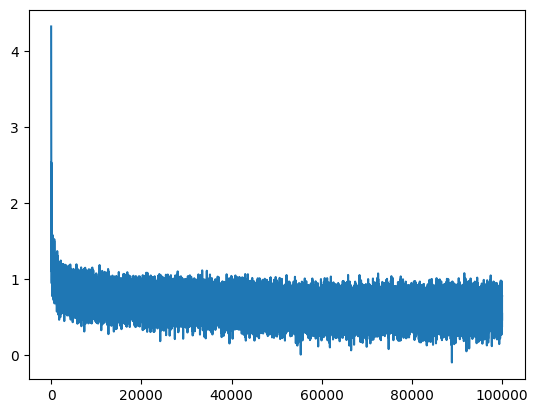

In [118]:
plt.plot(list(range(100000)), np.log(ls))

## Evaluate performance

In [119]:
Xemb = F.one_hot(Xtr, num_classes = vocab_size).float() @ C
inner_layer = (Xemb.view(Xemb.shape[0], -1) @ W1 + B1).relu()
logits = inner_layer @ W2 + B2
loss = F.cross_entropy(logits, Ytr)
print(f"Loss train: {loss.item()}")

Loss train: 1.8544554710388184


In [120]:
Xemb = F.one_hot(Xdev, num_classes = vocab_size).float() @ C
inner_layer = (Xemb.view(Xemb.shape[0], -1) @ W1 + B1).relu()
logits = inner_layer @ W2 + B2
loss = F.cross_entropy(logits, Ydev)
print(f"Loss dev: {loss.item()}")

Loss dev: 2.5345535278320312


In [122]:
Xemb = F.one_hot(Xte, num_classes = vocab_size).float() @ C
inner_layer = (Xemb.view(Xemb.shape[0], -1) @ W1 + B1).relu()
logits = inner_layer @ W2 + B2
loss = F.cross_entropy(logits, Yte)
print(f"Loss test: {loss.item()}")

Loss test: 2.4544787406921387


## Generation output

In [127]:
for _ in range(10):
    w = []
    X = [0]*3
    while(True):
        Xemb = F.one_hot(torch.tensor([X]), num_classes = vocab_size).float() @ C
        inner_layer = (Xemb.view(Xemb.shape[0], -1) @ W1 + B1).relu()
        logits = inner_layer @ W2 + B2
        probs = F.softmax(logits, dim=1)
        new_token = torch.multinomial(probs, 1).item()
        
        X = X+[new_token]
        X = X[1:]
    
        if new_token == 0:
            break
        
        w.append(new_token)
    print("".join([untokenize(ww) for ww in w]))

агапнела
дора
каксия
нур
корт
нидорасия
авгососиприна
ало
гольф
джаф


# Попробуем переписать на pytorch (с помощью LLM)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_d=2, n_tokens=3, inner_d=100):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_tokens = n_tokens
        
        self.embedding = nn.Embedding(vocab_size, emb_d)
        self.fc1 = nn.Linear(n_tokens * emb_d, inner_d)
        self.fc2 = nn.Linear(inner_d, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)  # Flatten the embedding
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [29]:
model = LanguageModel(vocab_size, emb_d=10, inner_d=100)

In [30]:
# Гиперпараметры
num_iterations = 100000
learning_rate = 0.01
batch_size = 32

def evaluate(model, X, Y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        loss = criterion(outputs, Y)
    return loss.item()

# Функция для получения случайного батча
def get_random_batch(X, Y, batch_size):
    indices = random.sample(range(len(X)), batch_size)
    return X[indices], Y[indices]

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for iteration in range(num_iterations):
    model.train()
    total_loss = 0
    # Получаем случайный батч
    batch_X, batch_Y = get_random_batch(Xtr, Ytr, batch_size)
    
    optimizer.zero_grad()
    outputs = model(batch_X)
    loss = criterion(outputs, batch_Y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    
    if (iteration + 1) % 1000 == 0:
        dev_loss = evaluate(model, Xdev, Ydev)
        print(f"Iteration {iteration+1}, Train Loss: {loss.item():.4f}, Dev Loss: {dev_loss:.4f}")

# Финальная оценка
final_dev_loss = evaluate(model, Xdev, Ydev)
print(f"Final Dev Loss: {final_dev_loss:.4f}")

Iteration 1000, Train Loss: 2.2100, Dev Loss: 2.3506
Iteration 2000, Train Loss: 1.5563, Dev Loss: 2.3828
Iteration 3000, Train Loss: 1.9790, Dev Loss: 2.4381
Iteration 4000, Train Loss: 1.7494, Dev Loss: 2.4578
Iteration 5000, Train Loss: 1.5965, Dev Loss: 2.5046
Iteration 6000, Train Loss: 1.7028, Dev Loss: 2.5477
Iteration 7000, Train Loss: 1.5224, Dev Loss: 2.6416
Iteration 8000, Train Loss: 1.9424, Dev Loss: 2.6663
Iteration 9000, Train Loss: 1.5371, Dev Loss: 2.6647
Iteration 10000, Train Loss: 1.7117, Dev Loss: 2.6548
Iteration 11000, Train Loss: 1.4958, Dev Loss: 2.6782
Iteration 12000, Train Loss: 2.2342, Dev Loss: 2.7517
Iteration 13000, Train Loss: 1.9900, Dev Loss: 2.7619
Iteration 14000, Train Loss: 1.9312, Dev Loss: 2.7911
Iteration 15000, Train Loss: 1.5894, Dev Loss: 2.8313
Iteration 16000, Train Loss: 2.1377, Dev Loss: 2.8390
Iteration 17000, Train Loss: 1.8777, Dev Loss: 2.9091
Iteration 18000, Train Loss: 1.5973, Dev Loss: 2.8588
Iteration 19000, Train Loss: 1.7580, 

In [37]:
def generate(model, max_length=100, temperature=1.0):
    model.eval()
    with torch.no_grad():
        x = torch.zeros(1, model.n_tokens, dtype=torch.long)
        generated = []
        for _ in range(max_length):
            logits = model(x)
            probs = F.softmax(logits / temperature, dim=1)
            next_token = torch.multinomial(probs, 1).item()
            
            if next_token == 0:  # Assuming 0 is the end token
                break
            
            generated.append(next_token)
            x = torch.cat([x[:, 1:], torch.tensor([[next_token]])], dim=1)

    return "".join(untokenize(l) for l in generated)

In [38]:
for _ in range(10):
    print(generate(model, temperature=1))

альфетра
авидольринонида
фомния
исианаманитифпамрелия
гуоргинит
жозтопелия
феон
парий
диодеттасисатта
гьлона


## Нарисуем карту embeddings

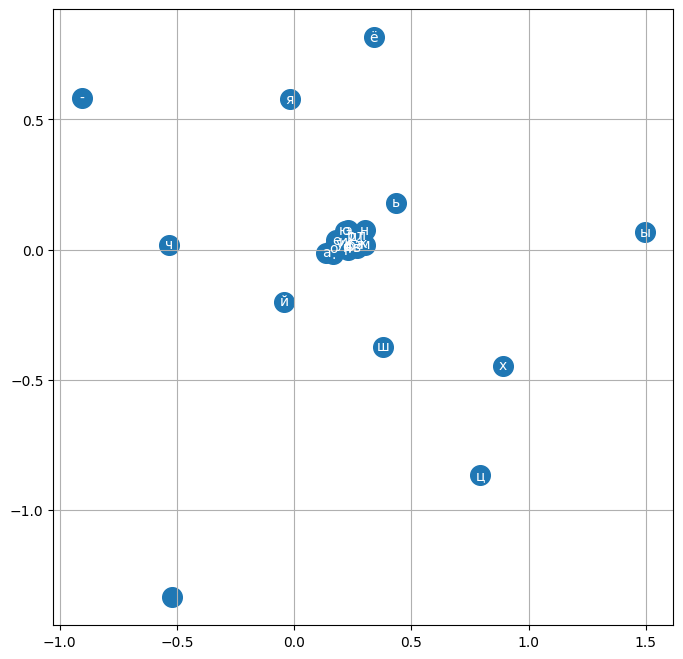

In [43]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), untokenize(i), ha="center", va="center", color='white')
plt.grid('minor')

In [50]:
C2 = model.embedding.weight.detach().numpy()

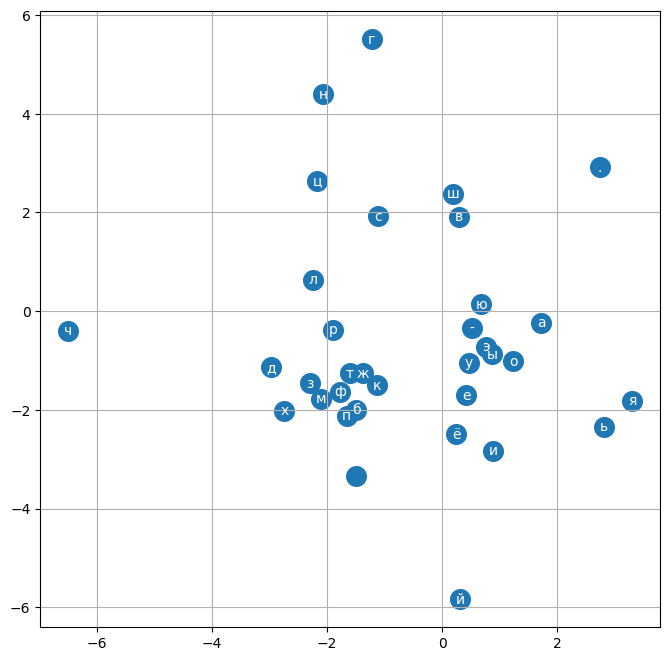

In [51]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C2[:,0].data, C2[:,1].data, s=200)
for i in range(C2.shape[0]):
    plt.text(C2[i,0].item(), C2[i,1].item(), untokenize(i), ha="center", va="center", color='white')
plt.grid('minor')

### Поиск гиперпараметров

In [41]:
from torch.utils.data import TensorDataset, DataLoader
import itertools

In [47]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    return total_loss / len(train_loader)

def hyperparameter_search(param_grid, vocab_size, n_tokens, n_samples, batch_size, epochs):
    train_dataset = TensorDataset(Xtr, Ytr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    best_loss = float('inf')
    best_params = None

    for params in itertools.product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))
        
        model = LanguageModel(vocab_size, **current_params)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())

        avg_loss = train_model(model, train_loader, criterion, optimizer, epochs)
        avg_loss = evaluate(model, Xdev, Ydev)

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = current_params

        print(f"Parameters: {current_params}, Loss: {avg_loss}")

    return best_params, best_loss

In [49]:
# Определение диапазонов гиперпараметров
param_grid = {
    'emb_d': [4, 8, 10, 12],
    'inner_d': [100, 150, 200, 250]
}

# Настройка эксперимента
vocab_size = 1000
n_samples = 1000
batch_size = 32
epochs = 5

best_params, best_loss = hyperparameter_search(param_grid, vocab_size, 3, n_samples, batch_size, epochs)

print(f"Best parameters: {best_params}")
print(f"Best loss: {best_loss}")

Parameters: {'emb_d': 4, 'inner_d': 100}, Loss: 2.404935836791992
Parameters: {'emb_d': 4, 'inner_d': 150}, Loss: 2.4564366340637207
Parameters: {'emb_d': 4, 'inner_d': 200}, Loss: 2.372823715209961
Parameters: {'emb_d': 4, 'inner_d': 250}, Loss: 2.367194890975952
Parameters: {'emb_d': 8, 'inner_d': 100}, Loss: 2.3527512550354004
Parameters: {'emb_d': 8, 'inner_d': 150}, Loss: 2.324859380722046
Parameters: {'emb_d': 8, 'inner_d': 200}, Loss: 2.326263189315796
Parameters: {'emb_d': 8, 'inner_d': 250}, Loss: 2.310490608215332
Parameters: {'emb_d': 10, 'inner_d': 100}, Loss: 2.332172155380249
Parameters: {'emb_d': 10, 'inner_d': 150}, Loss: 2.304330825805664
Parameters: {'emb_d': 10, 'inner_d': 200}, Loss: 2.302462339401245
Parameters: {'emb_d': 10, 'inner_d': 250}, Loss: 2.2986950874328613
Parameters: {'emb_d': 12, 'inner_d': 100}, Loss: 2.3037734031677246
Parameters: {'emb_d': 12, 'inner_d': 150}, Loss: 2.317249059677124
Parameters: {'emb_d': 12, 'inner_d': 200}, Loss: 2.274221658706665

In [50]:
model = LanguageModel(vocab_size, emb_d=12, inner_d=200)

In [51]:

# Гиперпараметры
num_iterations = 100000
learning_rate = 0.01
batch_size = 32

def evaluate(model, X, Y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        loss = criterion(outputs, Y)
    return loss.item()

# Функция для получения случайного батча
def get_random_batch(X, Y, batch_size):
    indices = random.sample(range(len(X)), batch_size)
    return X[indices], Y[indices]

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for iteration in range(num_iterations):
    model.train()
    total_loss = 0
    # Получаем случайный батч
    batch_X, batch_Y = get_random_batch(Xtr, Ytr, batch_size)
    
    optimizer.zero_grad()
    outputs = model(batch_X)
    loss = criterion(outputs, batch_Y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    
    if (iteration + 1) % 1000 == 0:
        dev_loss = evaluate(model, Xdev, Ydev)
        print(f"Iteration {iteration+1}, Train Loss: {loss.item():.4f}, Dev Loss: {dev_loss:.4f}")

# Финальная оценка
final_dev_loss = evaluate(model, Xdev, Ydev)
print(f"Final Dev Loss: {final_dev_loss:.4f}")

Iteration 1000, Train Loss: 2.2074, Dev Loss: 2.3803
Iteration 2000, Train Loss: 1.8488, Dev Loss: 2.3931
Iteration 3000, Train Loss: 1.3999, Dev Loss: 2.4950
Iteration 4000, Train Loss: 2.1928, Dev Loss: 2.5688
Iteration 5000, Train Loss: 1.5554, Dev Loss: 2.6794
Iteration 6000, Train Loss: 1.6433, Dev Loss: 2.6832
Iteration 7000, Train Loss: 2.1101, Dev Loss: 2.7721
Iteration 8000, Train Loss: 1.3934, Dev Loss: 2.7550
Iteration 9000, Train Loss: 1.1869, Dev Loss: 2.9030
Iteration 10000, Train Loss: 1.7279, Dev Loss: 2.9879
Iteration 11000, Train Loss: 1.6725, Dev Loss: 3.0113
Iteration 12000, Train Loss: 0.9819, Dev Loss: 3.1596
Iteration 13000, Train Loss: 1.7018, Dev Loss: 3.1031
Iteration 14000, Train Loss: 1.5931, Dev Loss: 3.2520
Iteration 15000, Train Loss: 2.0296, Dev Loss: 3.3354
Iteration 16000, Train Loss: 1.5111, Dev Loss: 3.3158
Iteration 17000, Train Loss: 1.5013, Dev Loss: 3.3546
Iteration 18000, Train Loss: 1.6581, Dev Loss: 3.3676
Iteration 19000, Train Loss: 1.5407, 